In [1]:
import pandas as pd
import nltk
import string
import seaborn as sns

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [3]:
yelp = pd.read_csv("new_yelp_eda_2000.csv")
yelp

,Rating,Label,Review_Text
0,5,-1,i love sakagura. ??its a bit hard to find but ...
1,4,1,"Ceviche mixto was great, the fish tacos were g..."
2,5,-1,Brooklyn's best-kept secret. Brunch and dinner...
3,2,1,Prepare to be annoyed. ??The food is unremarka...
4,4,-1,"Solid food, cute restaurant"
...,...,...,...
1995,5,-1,cheap and good thai food. you can try anything...
1996,2,-1,Good place w good environment but the fish was...
1997,3,1,Great Jones Cafe was a fun way to spend a Sund...
1998,5,-1,A diamond in the ruff. Food was fantastic and ...


### EDA

In [4]:
yelp['length'] = yelp['Review_Text'].apply(len)
yelp

,Rating,Label,Review_Text,length
0,5,-1,i love sakagura. ??its a bit hard to find but ...,391
1,4,1,"Ceviche mixto was great, the fish tacos were g...",268
2,5,-1,Brooklyn's best-kept secret. Brunch and dinner...,133
3,2,1,Prepare to be annoyed. ??The food is unremarka...,106
4,4,-1,"Solid food, cute restaurant",27
...,...,...,...,...
1995,5,-1,cheap and good thai food. you can try anything...,125
1996,2,-1,Good place w good environment but the fish was...,361
1997,3,1,Great Jones Cafe was a fun way to spend a Sund...,725
1998,5,-1,A diamond in the ruff. Food was fantastic and ...,86


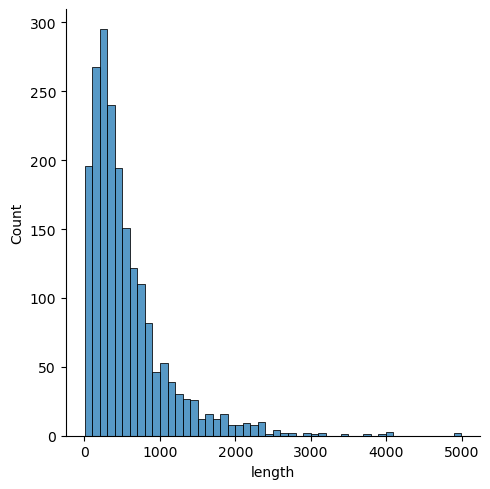

In [5]:
sns.displot(yelp['length'], bins=50)

## Sentiment Analysis

In [6]:
sen = pd.read_csv("data/vader_lexicon.txt",delimiter="\t", names=['token', 'polarity', 'none1', 'none2'])
sentiment = pd.DataFrame(sen.iloc[:, :2])
sentiment

,token,polarity
0,$:,-1.5
1,%),-0.4
2,%-),-1.5
3,&-:,-0.4
4,&:,-0.7
...,...,...
7512,}:,-2.1
7513,}:(,-2.0
7514,}:),0.4
7515,}:-(,-2.1


In [7]:
def sanitize_texts(df):
    punct_re = r"[^\w|^\s]"
    df["clean_text"] = df["Review_Text"].replace(punct_re, ' ', regex=True)
    return df

sanitize_texts(yelp)
yelp

,Rating,Label,Review_Text,length,clean_text
0,5,-1,i love sakagura. ??its a bit hard to find but ...,391,i love sakagura its a bit hard to find but ...
1,4,1,"Ceviche mixto was great, the fish tacos were g...",268,Ceviche mixto was great the fish tacos were g...
2,5,-1,Brooklyn's best-kept secret. Brunch and dinner...,133,Brooklyn s best kept secret Brunch and dinner...
3,2,1,Prepare to be annoyed. ??The food is unremarka...,106,Prepare to be annoyed The food is unremarka...
4,4,-1,"Solid food, cute restaurant",27,Solid food cute restaurant
...,...,...,...,...,...
1995,5,-1,cheap and good thai food. you can try anything...,125,cheap and good thai food you can try anything...
1996,2,-1,Good place w good environment but the fish was...,361,Good place w good environment but the fish was...
1997,3,1,Great Jones Cafe was a fun way to spend a Sund...,725,Great Jones Cafe was a fun way to spend a Sund...
1998,5,-1,A diamond in the ruff. Food was fantastic and ...,86,A diamond in the ruff Food was fantastic and ...


In [8]:
def to_tidy_format(df):
    tidy = (
        df["clean_text"]
        .str.lower()
        .str.split()
        .explode()
        .to_frame()
        .rename(columns={"clean_text": "word"})
    )
    return tidy

tidy_yelp = to_tidy_format(yelp)
tidy_yelp

,word
0,i
0,love
0,sakagura
0,its
0,a
...,...
1999,back
1999,for
1999,another
1999,special


In [30]:
def new_tidy(tidy_df):
    mapping = dict(sentiment[['token', 'polarity']].values)
    tidy_df['polarity'] = tidy_df.word.map(mapping)
    tidy_df = tidy_df.fillna(0)
    tidy_df = tidy_df.rename_axis(columns="index")
    tidy_df = tidy_df.drop(columns='word')
    return tidy_df

new_tidies = new_tidy(tidy_yelp)
new_tidies

index,polarity
0,0.0
0,3.2
0,0.0
0,0.0
0,0.0
...,...
1999,0.0
1999,0.0
1999,0.0
1999,1.7


In [31]:
print(new_tidies.columns)

Index(['polarity'], dtype='object', name='index')


In [32]:
import pandas as pd

def groupby(tidy_df):
    tidy_df = tidy_df.groupby(level=0)[['polarity']].agg(sum)
    return tidy_df

In [35]:
new_tidies_total = groupby(new_tidies)
new_tidies_total

index,polarity
0,4.6
1,16.9
2,9.6
3,-3.5
4,2.6
...,...
1995,7.0
1996,3.2
1997,20.8
1998,7.5


In [36]:
def df_add_polarity(tidy_df, df):
    df = df.rename_axis(columns="index")
    df['polarity'] = tidy_df['polarity']
    return df

yelp = df_add_polarity(new_tidies_total, yelp)
yelp

index,Rating,Label,Review_Text,length,clean_text,polarity
0,5,-1,i love sakagura. ??its a bit hard to find but ...,391,i love sakagura its a bit hard to find but ...,4.6
1,4,1,"Ceviche mixto was great, the fish tacos were g...",268,Ceviche mixto was great the fish tacos were g...,16.9
2,5,-1,Brooklyn's best-kept secret. Brunch and dinner...,133,Brooklyn s best kept secret Brunch and dinner...,9.6
3,2,1,Prepare to be annoyed. ??The food is unremarka...,106,Prepare to be annoyed The food is unremarka...,-3.5
4,4,-1,"Solid food, cute restaurant",27,Solid food cute restaurant,2.6
...,...,...,...,...,...,...
1995,5,-1,cheap and good thai food. you can try anything...,125,cheap and good thai food you can try anything...,7.0
1996,2,-1,Good place w good environment but the fish was...,361,Good place w good environment but the fish was...,3.2
1997,3,1,Great Jones Cafe was a fun way to spend a Sund...,725,Great Jones Cafe was a fun way to spend a Sund...,20.8
1998,5,-1,A diamond in the ruff. Food was fantastic and ...,86,A diamond in the ruff Food was fantastic and ...,7.5


In [38]:
import matplotlib.pyplot as plt

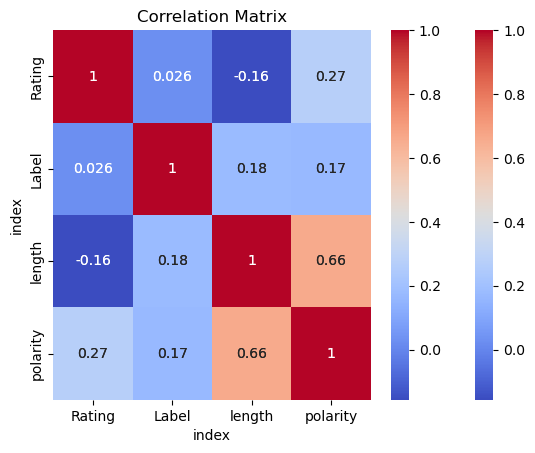

index,Rating,Label,length,polarity
index,,,,
Rating,1.000000,0.026293,-0.156664,0.273531
Label,0.026293,1.000000,0.177521,0.168906
length,-0.156664,0.177521,1.000000,0.660874
polarity,0.273531,0.168906,0.660874,1.000000


In [39]:
#Correlation of yelp: rating, label, length, polarity
correlation_matrix = yelp.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()
correlation_matrix

#strong positive correlation: length & polarity
#weak positive correlation: rating & label, rating & polarity, label & length, label & polarity
#weak negative correlation: rating & length

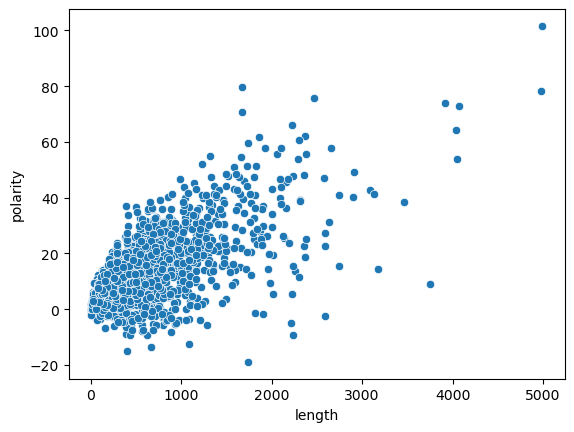

In [49]:
#show the correlation between rating and polarity in scatter diagram
sns.scatterplot(data=yelp, x="length", y="polarity")
plt.show()

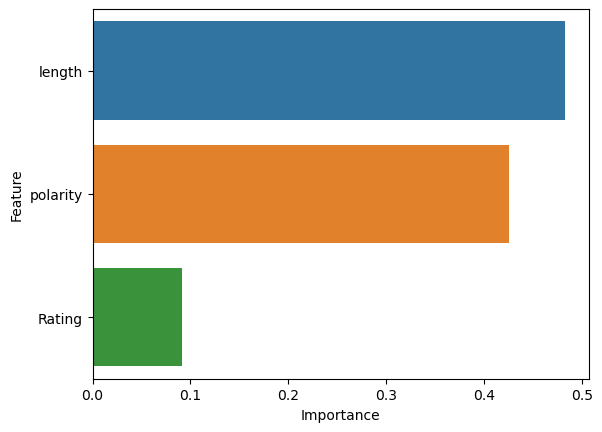

In [52]:
from sklearn.ensemble import RandomForestRegressor

# Split the DataFrame into features: rating, length and polarity (X) and target variable (y)
X = yelp.drop(['Label', 'Review_Text', 'clean_text'], axis=1)
y = yelp['Label']

# Create a Random Forest Regressor model
rf = RandomForestRegressor()

# Fit the model to your data
rf.fit(X, y)

# Get feature importances from the model
feature_importances = rf.feature_importances_

# Create a DataFrame from feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance values in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot using seaborn
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, orient='h')
plt.show()

#It shows length is the most important among these three features

In [55]:
feature_importance_df

,Feature,Importance
1,length,0.482806
2,polarity,0.425965
0,Rating,0.091229


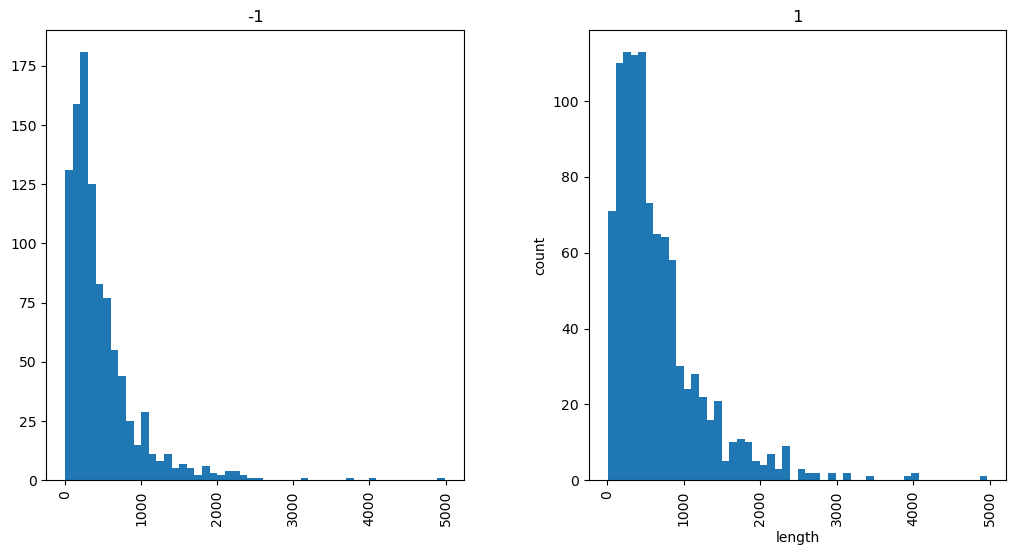

In [50]:
yelp.hist(column="length", by="Label", bins=50, figsize=(12,6))
plt.xlabel('length')
plt.ylabel('count')
plt.show()